In [1022]:
import numpy as np
import pandas as pd
import pickle

from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.preprocessing import StandardScaler, RobustScaler

# Кластеризация
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.neighbors import KNeighborsClassifier

# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1023]:
train_path = './train.csv'
test_path = './test.csv'

In [1024]:
data = pd.read_csv(train_path)
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [1025]:
data_test = pd.read_csv(test_path)

In [1026]:
data.Price.value_counts()

184966.930730    1
239277.453743    1
234999.673855    1
211043.111460    1
297144.369693    1
                ..
341186.588081    1
240738.133672    1
475135.921997    1
242275.324227    1
218714.077615    1
Name: Price, Length: 10000, dtype: int64

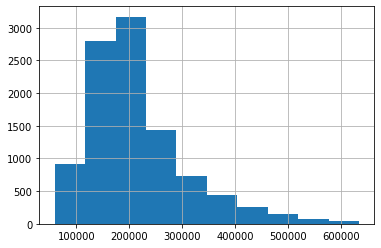

In [1027]:
_ = plt.hist(data.Price.sort_values())
plt.grid()

In [1028]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [1029]:
data.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Есть колонки с нечисловыми значениями. Посмотрим, что там.

In [1030]:
data.Ecology_2.value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [1031]:
data.Ecology_3.value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [1032]:
data.Shops_2.value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [1033]:
data = data.drop('Ecology_2', axis=1)
data = data.drop('Ecology_3', axis=1)
data = data.drop('Shops_2', axis=1)
data = data.drop('Id', axis = 1)
data = data.reset_index(drop=True)

Эти признаки не равномерно распределены. Скорее всего, сейчас их лучше просто убрать.

In [1034]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Social_1       10000 non-null  int64  
 10  Social_2       10000 non-null  int64  
 11  Social_3       10000 non-null  int64  
 12  Healthcare_1   5202 non-null   float64
 13  Helthcare_2    10000 non-null  int64  
 14  Shops_1        10000 non-null  int64  
 15  Price          10000 non-null  float64
dtypes: float64(8), int64(8)
memory usage: 1.2 MB


<AxesSubplot:>

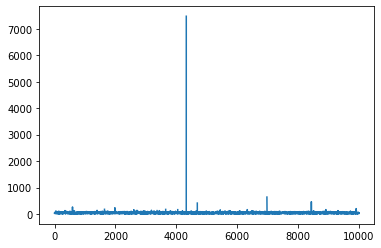

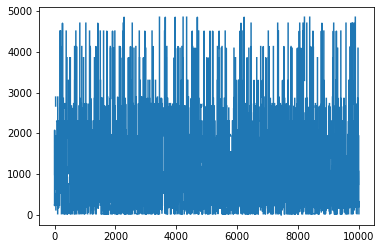

In [1035]:
# посмотрим на столбцы с null значениями
plt.figure()
data['LifeSquare'].plot()
plt.figure()
data['Healthcare_1'].plot()

In [1036]:
print(data['LifeSquare'].max())
print(data['LifeSquare'].mean())

7480.59212893
37.1996448277


In [1037]:
# Уберем строку, в которой был выброс по LifeSquare
data = data.drop(data['LifeSquare'].idxmax(), axis = 0)
data = data.reset_index()

<AxesSubplot:>

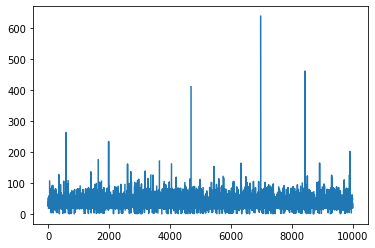

In [1038]:
# все равно есть значения, похожие на выбросы, поэтому нул значения заполним медианным
data['LifeSquare'].plot()

In [1039]:
data['LifeSquare'].describe()

count    7886.000000
mean       36.255771
std        20.275124
min         0.370619
25%        22.769574
50%        32.776846
75%        45.126159
max       638.163193
Name: LifeSquare, dtype: float64

In [1040]:
# найдем индексы значений, которые выходят за 3 сигмы от среднего значения
import traceback
def filter_3_sigma(df: pd.DataFrame) -> list:
    columns = df.columns.to_list()
    extra_val_idx_all = []
    if 'index' in columns:
        columns.pop(columns.index('index'))
    for col in columns:
        extra_val_idx_all.append(check_3_sigma(df[col]))
    return sorted(list(set(extra_val_idx_all)))

def check_3_sigma(column):
    extra_val_idx = set([])
    col_mean = column.mean()
    col_std = column.std()
    for idx, val in enumerate(column.values):
        if not (col_mean - 3*col_std < val < col_mean + 3*col_std):
            extra_val_idx.add(idx)
    # print(extra_val_idx)
    return extra_val_idx

In [1041]:
for col in data.columns.to_list():
    print(f'{col}: {len(check_3_sigma(data[col]))}')

index: 0
DistrictId: 88
Rooms: 22
Square: 93
LifeSquare: 2184
KitchenSquare: 6
Floor: 66
HouseFloor: 23
HouseYear: 1
Ecology_1: 61
Social_1: 0
Social_2: 176
Social_3: 340
Healthcare_1: 4885
Helthcare_2: 99
Shops_1: 294
Price: 175


Видно, что в LifeSquare и Healthcare_1 много значений, которые можно считать выбросами. Уберем эти столбцы из данных

In [1042]:
data = data.drop('Healthcare_1', axis=1)
data = data.drop('LifeSquare', axis=1)
data = data.reset_index(drop=True)
data.head()

,index,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price
0,0,35,2.0,47.981561,6.0,7,9.0,1969,0.089040,33,7976,5,0,11,184966.930730
1,1,41,3.0,65.683640,8.0,7,9.0,1978,0.000070,46,10309,1,1,16,300009.450063
2,2,53,2.0,44.947953,0.0,8,12.0,1968,0.049637,34,7759,0,1,3,220925.908524
3,3,58,2.0,53.352981,9.0,8,17.0,1977,0.437885,23,5735,3,0,5,175616.227217
4,4,99,1.0,39.649192,7.0,11,12.0,1976,0.012339,35,5776,1,2,4,150226.531644


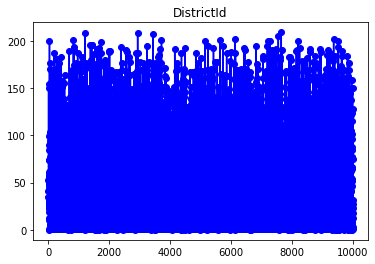

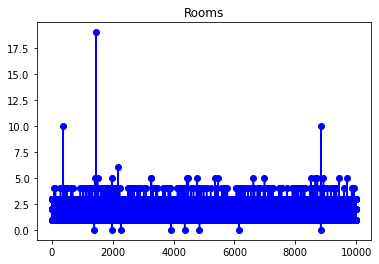

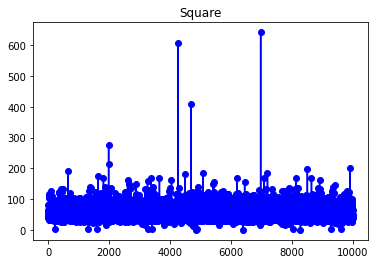

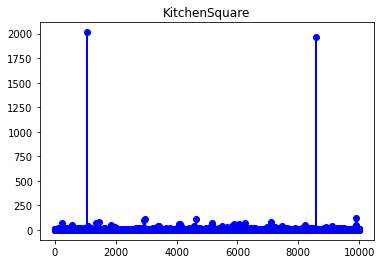

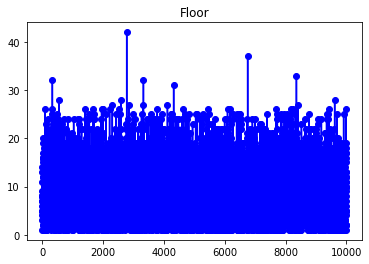

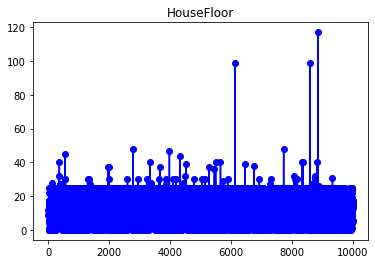

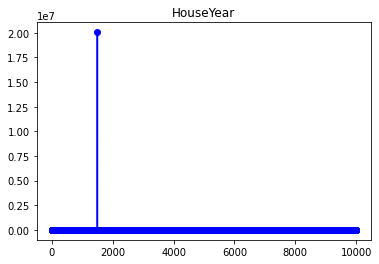

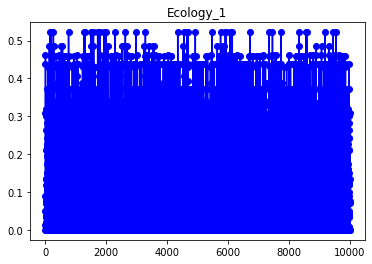

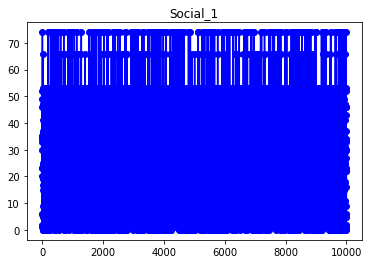

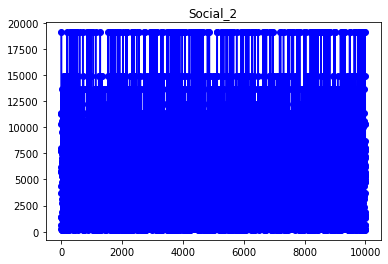

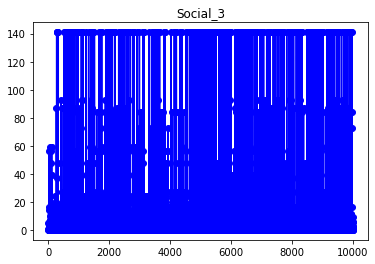

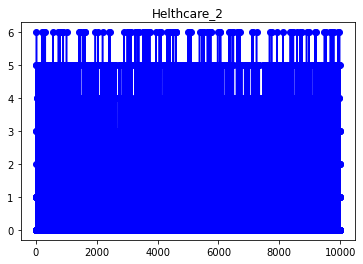

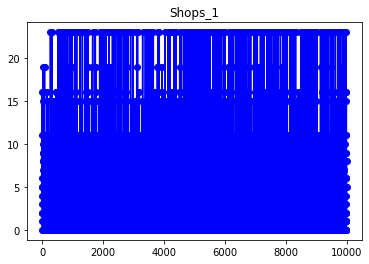

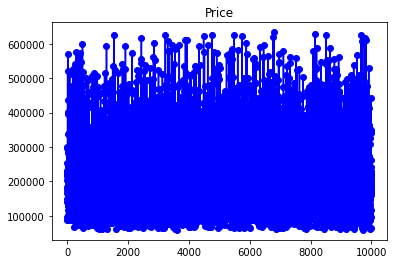

In [1043]:
for col in data.columns.to_list()[1:]:
    plt.figure()
    plt.plot(data[col], '-ob')
    plt.title(col)

In [1044]:
# В одной из строк с временем постройки дома явно ошибка заполнения.
data.HouseYear.max()

20052011

<AxesSubplot:>

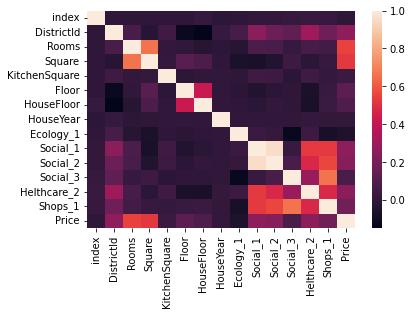

In [1045]:
sns.heatmap(data.corr())

In [1046]:
#Удалим всю эту строку
data = data.loc[data.HouseYear < 2022]
data.reset_index(drop=True)

,index,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price
0,0,35,2.0,47.981561,6.0,7,9.0,1969,0.089040,33,7976,5,0,11,184966.930730
1,1,41,3.0,65.683640,8.0,7,9.0,1978,0.000070,46,10309,1,1,16,300009.450063
2,2,53,2.0,44.947953,0.0,8,12.0,1968,0.049637,34,7759,0,1,3,220925.908524
3,3,58,2.0,53.352981,9.0,8,17.0,1977,0.437885,23,5735,3,0,5,175616.227217
4,4,99,1.0,39.649192,7.0,11,12.0,1976,0.012339,35,5776,1,2,4,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,9995,32,2.0,50.401785,5.0,6,5.0,1968,0.135650,46,7960,6,3,11,196684.316040
9993,9996,18,1.0,41.521546,9.0,13,13.0,2000,0.000000,30,5562,0,0,5,189050.289571
9994,9997,27,1.0,47.939008,1.0,12,16.0,2015,0.072158,2,629,1,0,0,159143.805370
9995,9998,75,2.0,43.602562,8.0,1,5.0,1961,0.307467,30,5048,9,2,5,181595.339808


In [1047]:
# в данных по площади кухни тоже какая-то ошибка. Больше позоже на год.
# вряд ли площадь будет больше 100м, поэтому сделаем отсечку
data.KitchenSquare.max()

2014.0

In [1048]:
data = data.loc[data.KitchenSquare < 100]
data = data.loc[data.Square < 300] 
data = data.loc[data.Rooms < 12]
data = data.loc[data.HouseFloor < 80]
data = data.reset_index(drop=True)


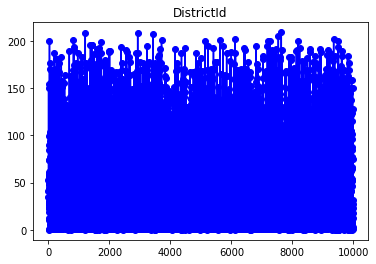

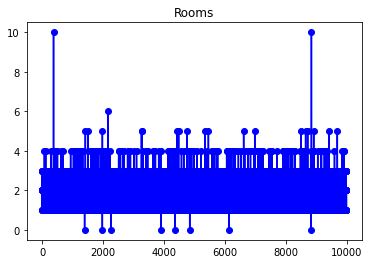

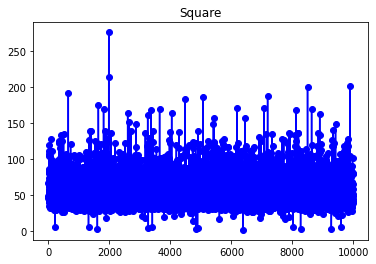

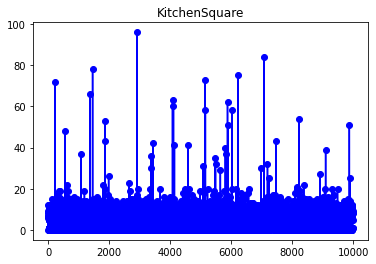

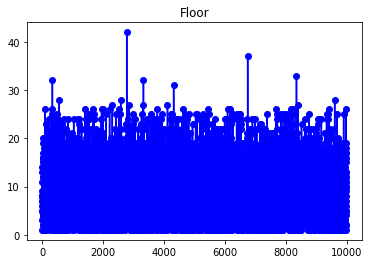

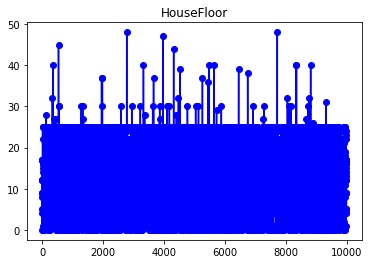

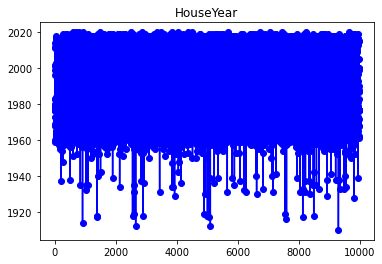

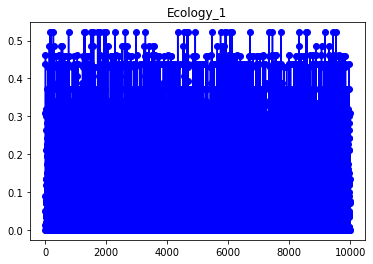

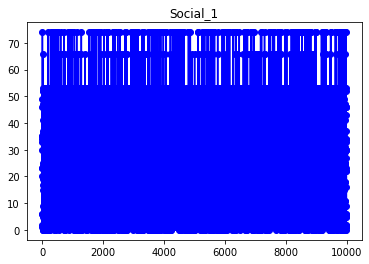

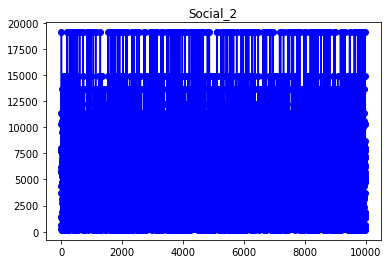

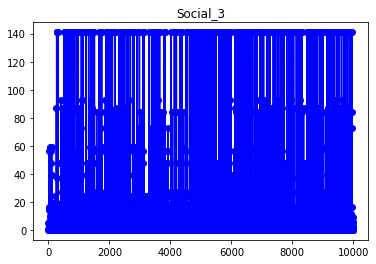

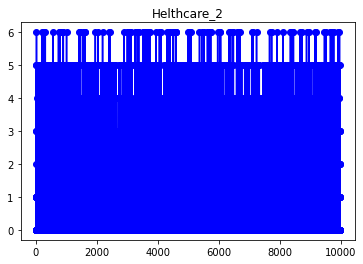

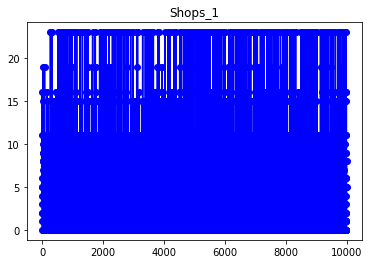

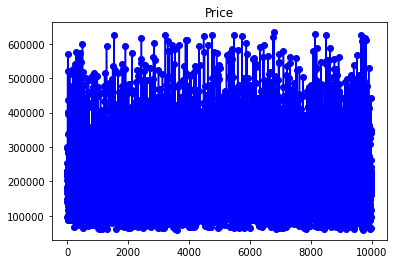

In [1049]:
# посмотрим на данные еще раз
for col in data.columns.to_list()[1:]:
    plt.figure()
    plt.plot(data[col], '-ob')
    plt.title(col)

In [1050]:
# # заполним недостающие значения в первом случае медианными значениями, во втором средними
# data['LifeSquare'] = data['LifeSquare'].fillna(data['LifeSquare'].median())  # медиана не подвержена влиянию выбросов
# data['Healthcare_1'] = data['Healthcare_1'].fillna(data['Healthcare_1'].mean())

In [1051]:
# for col in data.columns.to_list():
#     if col.lower() != 'index':
#         print(data[col].value_counts())

In [1052]:
data.Rooms.value_counts()

2.0     3875
1.0     3700
3.0     2231
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
Name: Rooms, dtype: int64

In [1053]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9985 entries, 0 to 9984
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          9985 non-null   int64  
 1   DistrictId     9985 non-null   int64  
 2   Rooms          9985 non-null   float64
 3   Square         9985 non-null   float64
 4   KitchenSquare  9985 non-null   float64
 5   Floor          9985 non-null   int64  
 6   HouseFloor     9985 non-null   float64
 7   HouseYear      9985 non-null   int64  
 8   Ecology_1      9985 non-null   float64
 9   Social_1       9985 non-null   int64  
 10  Social_2       9985 non-null   int64  
 11  Social_3       9985 non-null   int64  
 12  Helthcare_2    9985 non-null   int64  
 13  Shops_1        9985 non-null   int64  
 14  Price          9985 non-null   float64
dtypes: float64(6), int64(9)
memory usage: 1.1 MB


In [1054]:
# X = data.drop('Price', axis=1)
from operator import delitem


data = data.loc[data.KitchenSquare < 100]
data = data.loc[data.Square < 300] 
data = data.loc[data.Rooms < 15]

# X = data[['Square', 'Rooms', 'Shops_1', 'HouseYear', 'KitchenSquare']]
X = data.drop(['Price'], axis=1)
# X = data[['Square', 'KitchenSquare']]
y = data['Price']

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=42)
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True), y_train.reset_index(drop=True), y_test.reset_index(drop=True)

(9985, 14)
(9985,)


In [1055]:
scaler = RobustScaler()

colnames = X.columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=colnames)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=colnames)

X_train_scaled.head(2)

,index,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1
0,0.473526,0.163636,0.0,-0.181114,-0.125,-0.375,-0.875,-0.370370,-0.42341,0.733333,1.065513,-0.4,1.0,0.4
1,-0.606752,0.854545,0.0,-0.207534,-0.125,-0.125,-0.875,-0.518519,-0.38930,0.166667,0.000000,-0.4,2.5,0.6


In [1056]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(7488, 14)
(2497, 14)


In [1057]:
X_train_scaled.describe()

,index,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1
count,7488.000000,7488.000000,7488.000000,7488.000000,7488.000000,7488.000000,7488.000000,7488.000000,7488.000000,7488.000000,7488.000000,7488.000000,7488.000000,7488.000000
mean,-0.007922,0.245862,-0.111378,0.148604,-0.021000,0.189887,0.067491,0.287645,0.240168,-0.014356,0.004249,1.196368,0.152978,0.241934
std,0.579291,0.792611,0.819255,0.795522,0.586542,0.653970,0.823727,0.682372,0.668277,0.583887,0.701545,4.738480,0.738114,0.955382
min,-1.015875,-0.672727,-2.000000,-2.128544,-0.750000,-0.750000,-1.500000,-2.481481,-0.423410,-0.833333,-0.903585,-0.400000,-0.500000,-0.600000
25%,-0.507937,-0.309091,-1.000000,-0.449881,-0.625000,-0.375000,-0.375000,-0.111111,-0.324344,-0.633333,-0.657072,-0.400000,-0.500000,-0.400000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.492063,0.690909,0.000000,0.550119,0.375000,0.625000,0.625000,0.888889,0.675656,0.366667,0.342928,0.600000,0.500000,0.600000
max,0.993168,3.109091,8.000000,9.209537,8.625000,4.375000,4.500000,1.592593,2.506222,1.633333,2.436518,27.800000,2.500000,4.000000


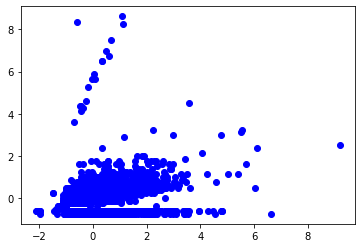

In [1058]:
plt.plot(X_train_scaled.Square, X_train_scaled.KitchenSquare, 'ob')

In [1059]:
def reduce_dims(df, dims=2, method='pca', perplexity=30):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames) 

def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    figsize = (10, 7)
    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=figsize)
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5)

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()

def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    if labels is not None:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   c=components_with_labels_df.iloc[:, -1], 
                   cmap=plt.get_cmap('jet'), alpha=0.5)
    else:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   alpha=0.5)

    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    plt.title('3D mapping of objects')
    plt.show()

**Кластеризация**

In [1065]:
def display_clusters_distribution(unique_labels, labels_counts):
    """Визуализация распределения классов по кластерам"""
    plt.figure(figsize=(8,5))

    plt.bar(unique_labels, labels_counts)

    plt.xlabel('Clusters')
    plt.xticks(unique_labels)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

def apply_elbow_method(X):
    """Визуализация для метода 'локтя'"""
    
    distortions = []
    K = range(2,30)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [1066]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [1067]:
from colour import TVS_ILLUMINANTS_HUNTERLAB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def gen_pred_models(X_train, y_train, X_test, y_test, labels_train, labels_test):
    y_pred_lst = []
    labels_num = max(labels_train) + 1
    lr_arr = np.asarray([RandomForestRegressor(n_estimators=50, max_depth=25, random_state=100 - i) for i in range(labels_num)])
    try:
        for idx in range(lr_arr.size):
            lr_arr[idx].fit(X_train.loc[labels_train == idx], y_train[labels_train == idx])

            y_test_pred = lr_arr[idx].predict(X_test.loc[labels_test == idx])
            y_pred_lst.append(y_test_pred)
            temp_res = r2_score(y_test[labels_test == idx], y_test_pred)
            print(f'{idx}: {temp_res}')
        return y_pred_lst
    except ValueError:
        print(traceback.format_exc())
        print(idx)
        print(lr_arr)
        print(labels_num)

In [1068]:
_, X_train_tsne = reduce_dims(X_train_scaled, dims=2, method='tsne', perplexity=70)
_, X_test_tsne =reduce_dims(X_test_scaled, dims=2, method='tsne', perplexity=70)

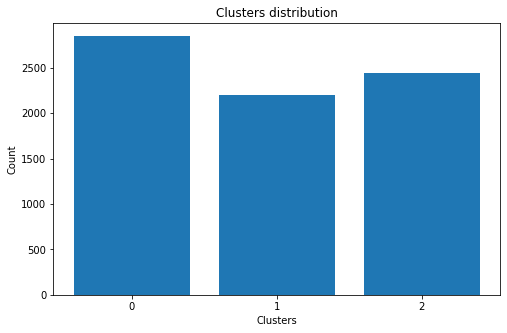

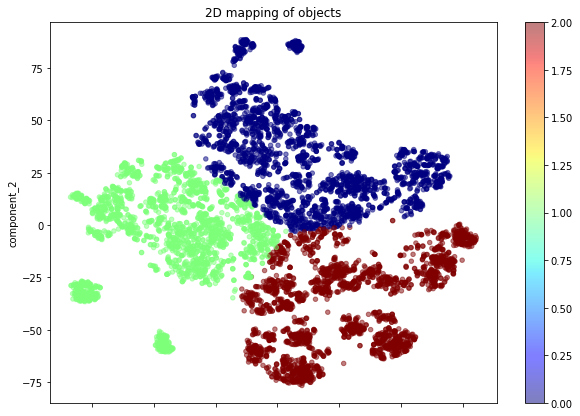

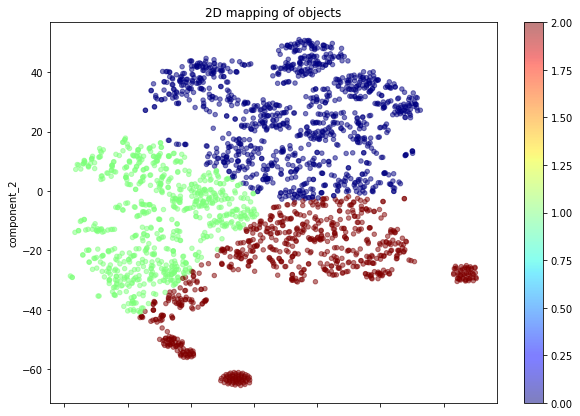

In [1098]:
model_kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_train_labels = model_kmeans.fit_predict(X_train_tsne)
kmeans_train_labels = pd.Series(kmeans_train_labels, name='kmeans_train_labels')
kmeans_test_labels = model_kmeans.predict(X_test_tsne)
kmeans_test_labels = pd.Series(kmeans_test_labels, name='kmeans_test_labels')

unique, counts = np.unique(kmeans_train_labels, return_counts=True)
display_clusters_distribution(unique, counts)
display_components_in_2D_space(X_train_tsne, kmeans_train_labels)
display_components_in_2D_space(X_test_tsne, kmeans_test_labels)

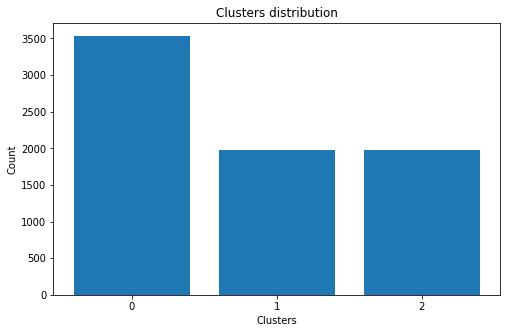

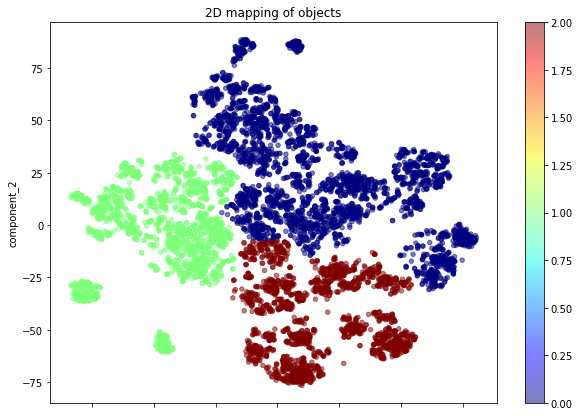

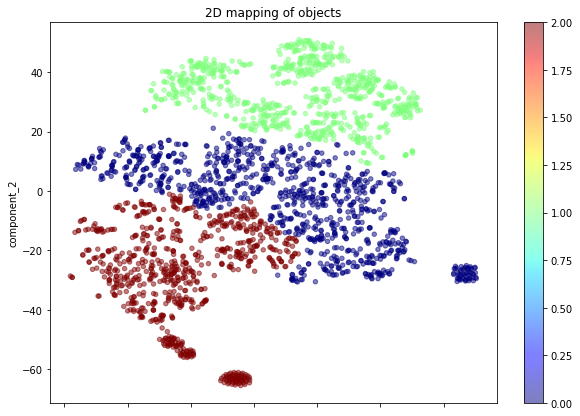

In [1099]:
aggl_model = AgglomerativeClustering(n_clusters=3)
aggl_train_labels = aggl_model.fit_predict(X_train_tsne)
aggl_test_labels = aggl_model.fit_predict(X_test_tsne)
# labels_clast = pd.Series(labels_clast)

unique, counts = np.unique(aggl_train_labels, return_counts=True)
display_clusters_distribution(unique, counts)
display_components_in_2D_space(X_train_tsne, labels=aggl_train_labels)
display_components_in_2D_space(X_test_tsne, labels=aggl_test_labels)

**Создаине и обучние модели**

In [1102]:
model_forest = RandomForestRegressor(max_depth=15, n_estimators=50, random_state=42)
lab_idx = 2
model_forest.fit(X_train[kmeans_train_labels== lab_idx], y_train[kmeans_train_labels == lab_idx])
y_forest_pred_0 = model_forest.predict(X_test[kmeans_test_labels == lab_idx])

r2_score(y_test[kmeans_test_labels == lab_idx], y_forest_pred_0)



0.40756049634016756

In [1103]:
y_test_pred_lst = gen_pred_models(X_train, y_train, X_test, y_test, aggl_train_labels, aggl_test_labels)

0: 0.6546096056705999
1: -0.3201886517316388
2: 0.3279237016557581


In [1104]:


y_test_all = np.hstack((y_test[aggl_test_labels == 0].values.reshape(-1), 
                        y_test[aggl_test_labels == 1].values.reshape(-1),
                        y_test[aggl_test_labels == 2].values.reshape(-1), 
                        ))
y_test_pred_all = np.hstack((y_test_pred_lst[0].reshape(-1), 
                             y_test_pred_lst[1].reshape(-1),
                             y_test_pred_lst[2].reshape(-1) 
                             ))

# результаты от кластера 2 тянут на дно
r2_score(y_test_all, y_test_pred_all)



0.41278461401970301

In [1076]:
model_forest = RandomForestRegressor(max_depth=25, n_estimators=50, random_state=42)
# lab_idx = 0
model_forest.fit(X_train, y_train)
y_forest_pred_0 = model_forest.predict(X_test)

r2_score(y_test, y_forest_pred_0)


0.7173016850506444